# Quantum Spectral Clustering: an hybrid based quantum kernel approach.

This study investigates the integration of quantum computing techniques with spectral clustering algorithms, proposing and evaluating a hybrid approach that combines quantum kernels and feature maps with classical spectral clustering. Extensive experimentation on two datasets, including the ad_hoc dataset from Qiskit and a synthetic complex dataset, reveals that quantum spectral clustering, particularly utilizing the ZZFeatureMap, outperforms classical methods in identifying clusters, especially in datasets with non-linear separability and high complexity. However, computational trade-offs exist, with quantum methods showing higher accuracy on smaller datasets but requiring exponentially more computational time as dataset size increases. The findings underscore the current limitations of quantum simulation on classical hardware and highlight the need for advancements in quantum hardware development to realize the full potential of quantum algorithms. While promising, practical challenges such as scalability and computational efficiency remain, suggesting avenues for future research including scalability enhancement, adaptive feature maps, error mitigation strategies, and exploration of hybrid quantum-classical algorithms for more efficient utilization of quantum resources.

# Environment Setup and Library Imports
To ensure the successful execution of our quantum spectral clustering experiments, we begin by setting up our environment with the necessary libraries and packages. This setup involves two primary steps: installing dependencies and importing libraries.


## Installed Dependencies
We install qiskit and qiskit-machine-learning with additional support for PyTorch integration. These packages provide us with the tools required for quantum computing and quantum machine learning tasks, including feature map construction, quantum circuit simulation, and kernel estimation.

In [ ]:
!pip uninstall qiskit qiskit-algorithms qiskit-machine-learning

In [ ]:
!pip install qiskit==0.46.0
!pip install qiskit-algorithms==0.2.2
!pip install qiskit-machine-learning==0.7.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.9/306.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512565 sha256=39c7bdd7e4b597d0b922a64127648a28e20e7ce45b2f7f42af

In [ ]:
# Verify that libraries have been installed with the right version
!pip list | grep qiskit

qiskit                           0.46.0
qiskit-algorithms                0.2.2
qiskit-machine-learning          0.7.1
qiskit-terra                     0.46.0


In [ ]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=4bfc3335567698314fc3bae3e20ba4d4a5702852197944f398ef94f5e4169664
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


## Imported Libraries
Our experiment leverages a combination of classical data processing, machine learning techniques, and quantum computing libraries:

- **NumPy**: For efficient numerical computations.
- **Scikit-learn**: Offers various machine learning tools for clustering (`KMeans`, `SpectralClustering`), metrics (`normalized_mutual_info_score`), and data preprocessing (`StandardScaler`, `PCA`).
- **Matplotlib**: For visualizing data and results.
- **Qiskit**: Provides quantum computing functionalities, including quantum circuit design (`ZZFeatureMap`), sampling (`Sampler`), and kernel estimation (`FidelityQuantumKernel`) within a machine learning context.


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_kernels, rbf_kernel, euclidean_distances
from sklearn.datasets import make_blobs, make_swiss_roll
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import pandas as pd

from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV


from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 12345

from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
import pylatexenc

# Dataset

In this section, we explore two distinct datasets, each offering unique challenges and insights for our quantum spectral clustering experiments. These datasets include a custom ad-hoc dataset and a synthetically generated dataset. For each dataset, we detail the process of acquisition or generation, specify any relevant hyperparameters, visualize the data, and examine its dimensionality reduction through PCA and t-SNE techniques.

## AD_HOC dataset

The ad-hoc dataset is specifically designed for benchmarking quantum machine learning algorithms. It consists of structured data points that facilitate the demonstration of quantum advantage in clustering tasks.

### Data Acquisition

In [ ]:
from qiskit_machine_learning.datasets import ad_hoc_data

### Hyperparameters Definition

In [ ]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=30,
    test_size=0,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

### Dataset Visualization

In [ ]:
def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    filtered_indices = np.where(labels == class_label)
    ax.scatter(
        features[filtered_indices, 0].flatten(),  # Ensuring 2D access and flattening to 1D
        features[filtered_indices, 1].flatten(),  # Ensuring 2D access and flattening to 1D
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
        s=100,  # Marker size
    )

def plot_dataset(features, labels, background_data):
    plt.figure(figsize=(6, 6))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(background_data).T,
        interpolation="nearest",
        origin="lower",
        cmap="coolwarm",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )

    # Plotting features with labels "Class A" and "Class B"
    ax = plt.gca()
    plot_features(ax, features, labels, 0, "^", "orange", "none", "Class A")
    plot_features(ax, features, labels, 1, "s", "white", "red", "Class B")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset visualization")

    plt.show()

Plot the ad_hoc dataset before clustering: points and ground-truth.

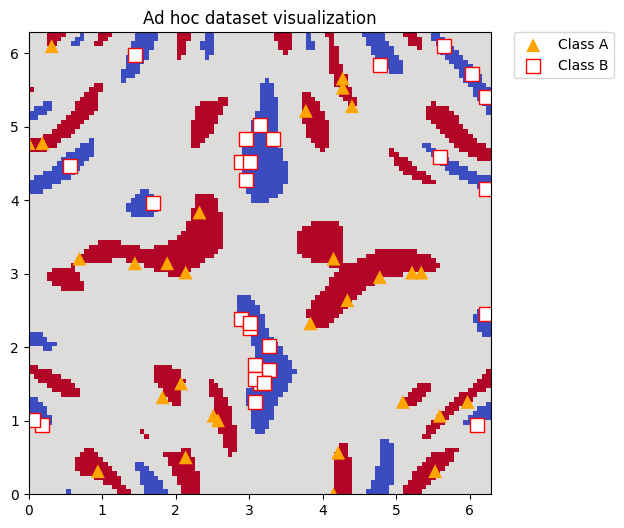

In [ ]:
plot_dataset(train_features, train_labels, adhoc_total)

### PCA and t-SNE Analysis

**PCA Analysis**

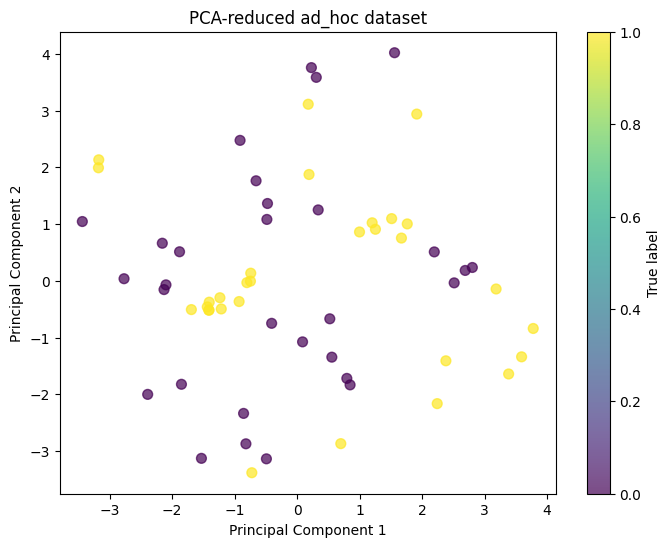

In [ ]:
pca = PCA(n_components=2)
train_features_pca = pca.fit_transform(train_features)

plt.figure(figsize=(8, 6))
plt.scatter(train_features_pca[:, 0], train_features_pca[:, 1], c=train_labels, cmap='viridis', s=50, alpha=0.7)
plt.title('PCA-reduced ad_hoc dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='True label')
plt.show()

**t-SNE Analysis**

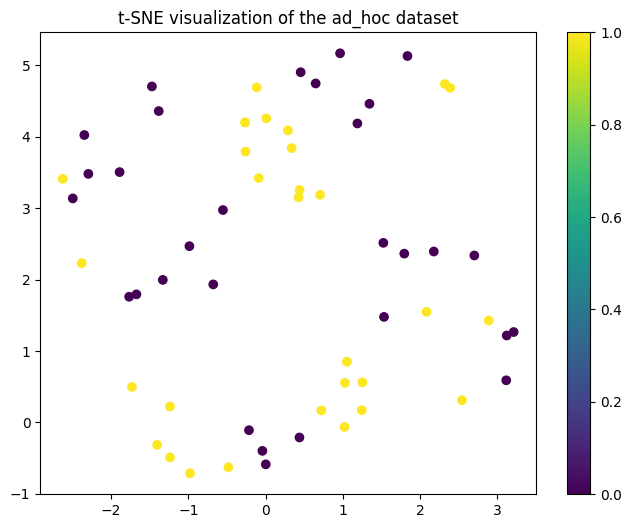

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
train_features_tsne = tsne.fit_transform(train_features)

plt.figure(figsize=(8, 6))
plt.scatter(train_features_tsne[:, 0], train_features_tsne[:, 1], c=train_labels, cmap='viridis')
plt.title('t-SNE visualization of the ad_hoc dataset')
plt.colorbar()
plt.show()

## Synthetic dataset
In our exploration of quantum spectral clustering, we also evaluate the algorithm's performance on a synthetic dataset, which is designed to simulate more complex structures found in real-world data. For this purpose, we use the Swiss roll dataset, a commonly used test set in machine learning for tasks requiring the understanding of intricate three-dimensional manifolds.

 ### Dataset generation
 The synthetic dataset is generated using the **make_swiss_roll** function from Scikit-learn, which creates a 3D Swiss roll-shaped dataset. To increase the complexity and introduce non-linearity, we apply a transformation to the third dimension of the dataset. Specifically, we replace the 'z' values of the data points with their sine values, effectively distorting the Swiss roll into a more convoluted shape. This non-linearity ensures that classical linear methods struggle with clustering, thereby providing a stringent test for our quantum clustering approach.

In [ ]:
def generate_complex_dataset(n_samples=500, noise=0.5):
    data, color = make_swiss_roll(n_samples=n_samples, noise=noise)
    # Apply a non-linear transformation to make it more challenging
    z = data[:, 2]
    data[:, 2] = np.sin(z)
    return data, color

In [ ]:
# Generate datapoints with default
n_samples = 50
data, color = generate_complex_dataset(n_samples)

### Dataset Visualization

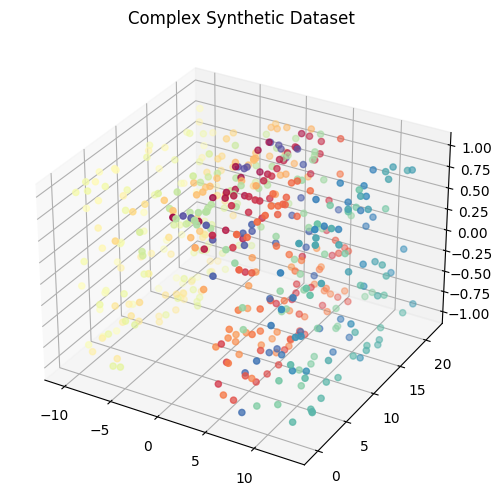

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#fig = plt.figure()
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=color, cmap=plt.cm.Spectral)
plt.title("Complex Synthetic Dataset")
plt.show()

The resulting plot illustrates the twisted and non-linear nature of the dataset, highlighting the need for sophisticated clustering methods that can capture the underlying structure of the data. The color map plt.cm.Spectral is chosen to provide a clear visual distinction between different sections of the Swiss roll, enhancing the three-dimensional effect.

### PCA and t-SNE Analysis

In [ ]:
# Generate the synthetic dataset - comment if you don't need to produce new data
data, color = generate_complex_dataset(n_samples=100)

**PCA Analysis**

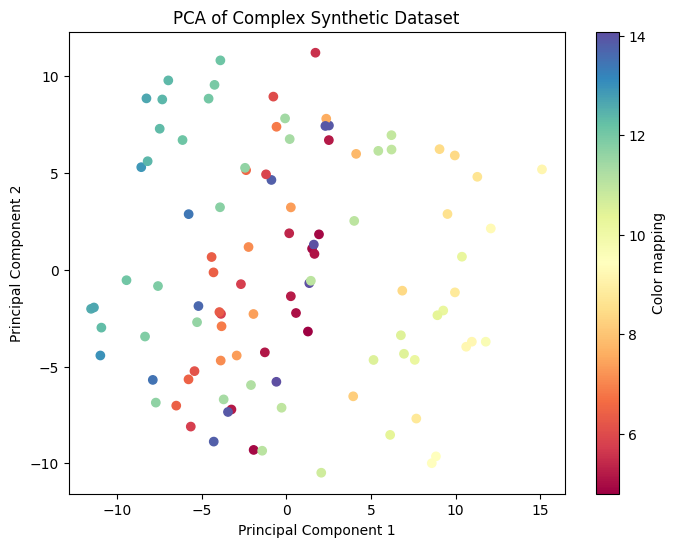

In [ ]:
# Perform PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

# Plot the PCA-reduced data
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title('PCA of Complex Synthetic Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Color mapping')

plt.show()

The continuous nature of the color gradient and the distribution of data points suggest that clustering algorithms would face a challenge in defining clear boundaries between potential clusters. This complexity is an opportunity to evaluate the effectiveness of quantum spectral clustering, where the ability to process high-dimensional Hilbert spaces might capture nuances that PCA cannot.

**t-SNE Analysis**

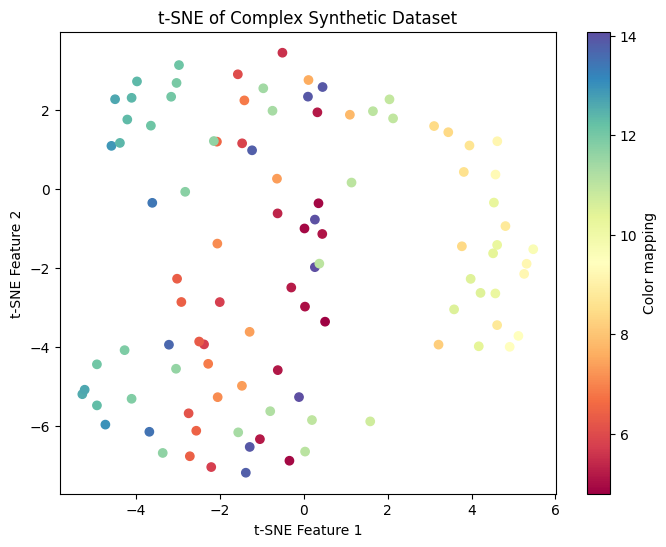

In [ ]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=123)
data_tsne = tsne.fit_transform(data)


# Plot the t-SNE reduced data
plt.figure(figsize=(8, 6))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title('t-SNE of Complex Synthetic Dataset')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar(label='Color mapping')

#plt.tight_layout()
plt.show()


The distribution and gradient of colors suggest the presence of non-linear patterns and varying densities across the dataset, emphasizing the complexity of the underlying data structure. This non-linear dimensionality reduction highlights potential clusters that quantum spectral clustering could further elucidate, showcasing the need for advanced techniques in handling such intricate datasets.

# Quantum Spectral Clustering

## ZZFeatureMap

We initialize a ZZFeatureMap with specified parameters:
- `feature_dimension`: The dimensionality of the feature space. This parameter is determined based on the dimensionality of the classical data.
- `reps`: The number of repetitions of the entangling layers in the quantum circuit.
- `entanglement`: The pattern of entanglement between qubits in the quantum circuit. Here, we choose "linear" entanglement.

Then, we initialize a FidelityQuantumKernel with the ZZFeatureMap:
- `feature_map`: The ZZFeatureMap instance used for embedding.

Finally, we evaluate the FidelityQuantumKernel on the training features to compute the kernel matrix, which represents the similarity between data points in the quantum space.

### hyperparameter optimization
In this subsection I perform the hyperparameter optimization of the number of **reps**, using gridsearch.

In [ ]:
def hyperparameter_optimization_zzfeaturemap(data, labels, feature_dimension, num_reps_range, n_clusters):
    best_score = 0
    best_params = None

    for num_reps in num_reps_range:
        # Initialize ZZFeatureMap with specified parameters
        zz_feature_map = ZZFeatureMap(feature_dimension=feature_dimension, reps=num_reps)

        # Initialize FidelityQuantumKernel with ZZFeatureMap
        quantum_kernel = FidelityQuantumKernel(feature_map=zz_feature_map)

        # Compute the kernel matrix using the quantum kernel
        kernel_matrix = quantum_kernel.evaluate(x_vec=data)

        # Initialize SpectralClustering model with specified number of clusters
        spectral_model = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')

        # Perform clustering on the precomputed affinity matrix
        cluster_labels = spectral_model.fit_predict(kernel_matrix)

        # Compute the Normalized Mutual Information (NMI) score for clustering evaluation
        cluster_score = normalized_mutual_info_score(cluster_labels, labels)

        # Check if the current score is better than the previous best score
        if cluster_score > best_score:
            best_score = cluster_score
            best_params = {'num_reps': num_reps, 'score': cluster_score}

    return best_params

### ad_hoc dataset experiment

In [ ]:
# Initialize ZZFeatureMap with specified parameters
zz_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

# Initialize FidelityQuantumKernel with ZZFeatureMap
quantum_kernel = FidelityQuantumKernel(feature_map=zz_feature_map)

# Evaluate the kernel on the training features to compute the kernel matrix
quantum_kernel_matrix = quantum_kernel.evaluate(x_vec=train_features)

Plot the Quantum Circuit

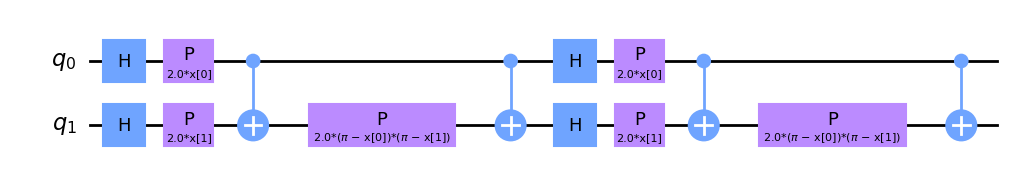

In [ ]:
# Decompose the circuit to see the underlying gates
decomposed_circuit = zz_feature_map.decompose()

# Now draw the decomposed circuit
decomposed_circuit.draw('mpl')

We generate a visualization of the kernel matrix obtained from the quantum kernel. The kernel matrix represents the pairwise similarities between data points in the quantum feature space. Visualizing this matrix provides insights into the clustering structure of the data in the quantum space.


In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(np.asmatrix(quantum_kernel_matrix), interpolation="nearest", origin="upper", cmap="Blues")
plt.title("Quantum clustering kernel matrix of ad_hoc dataset")
plt.show()

We initialize a SpectralClustering model with the following parameters:
- `n_clusters`: The number of clusters to identify. Here, we choose 2 clusters.
- `affinity`: The affinity matrix used to capture the relationship between data points. We use a precomputed affinity matrix obtained from the kernel matrix.

Then, we fit the SpectralClustering model to the precomputed affinity matrix (`quantum_kernel_matrix`) and predict cluster labels for the data points.

We evaluate the clustering performance using the Normalized Mutual Information (NMI) score, which measures the agreement between the true labels and the predicted clusters. Higher NMI scores indicate better clustering performance.

In [ ]:
# Initialize SpectralClustering model with specified parameters
quantum_spectral_model = SpectralClustering(n_clusters=2, affinity="precomputed")

# Perform clustering on the precomputed affinity matrix
cluster_labels = quantum_spectral_model.fit_predict(quantum_kernel_matrix)

# Compute the Normalized Mutual Information (NMI) score for clustering evaluation
cluster_score = normalized_mutual_info_score(cluster_labels, train_labels)

# Print the clustering score
print(f"Clustering score: {cluster_score}")

Clustering score: 1.0


plotting the results

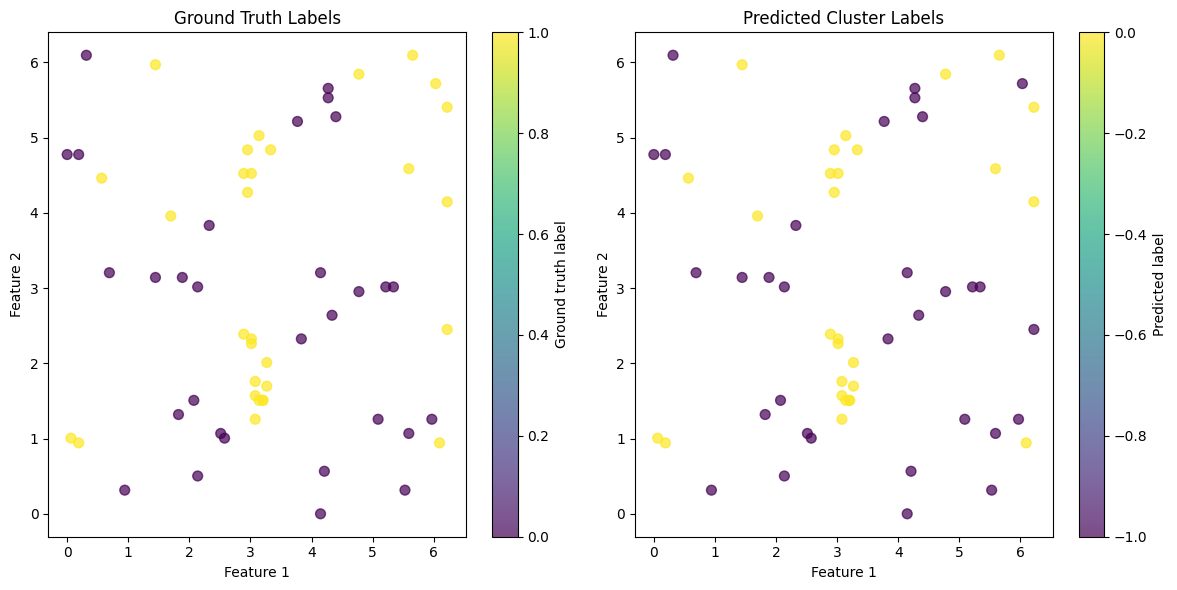

In [ ]:
# Plot the ground truth labels
plt.figure(figsize=(12, 6))

# Ground truth plot
plt.subplot(1, 2, 1)
plt.scatter(train_features[:, 0], train_features[:, 1], c=train_labels, cmap='viridis', s=50, alpha=0.7)
plt.title('Ground Truth Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Ground truth label')

# Predicted labels plot
plt.subplot(1, 2, 2)
plt.scatter(train_features[:, 0], train_features[:, 1], c=cluster_labels * -1, cmap='viridis', s=50, alpha=0.7)
plt.title('Predicted Cluster Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Predicted label')

plt.tight_layout()
plt.show()

### synthetic dataset experiment

We initialize a ZZFeatureMap with the following parameters:
- `feature_dimension`: The dimensionality of the feature space, or in this case, number of qubits.
- `reps`: The number of repetitions of the entangling layers in the quantum circuit.

Then, we initialize a FidelityQuantumKernel with the ZZFeatureMap:
- `feature_map`: The ZZFeatureMap instance used for embedding.

Next, we compute the kernel matrix using the quantum kernel:
- `x_vec`: The classical data points to be embedded into the quantum space.

We initialize a SpectralClustering model with the following parameters:
- `n_clusters`: The number of clusters to identify. Here, we choose 6 clusters, one for each color.
- `affinity`: The affinity matrix used to capture the relationship between data points. We use a precomputed affinity matrix obtained from the kernel matrix.

Then, we fit the SpectralClustering model to the precomputed affinity matrix (`kernel_matrix`) and predict cluster labels for the data points.

We evaluate the clustering performance using the Normalized Mutual Information (NMI) score, which measures the agreement between the true labels and the predicted clusters. Higher NMI scores indicate better clustering performance.

In [ ]:
# Initialize ZZFeatureMap with specified parameters
zz_feature_map = ZZFeatureMap(feature_dimension=3, reps=4)

# Initialize FidelityQuantumKernel with ZZFeatureMap
quantum_kernel = FidelityQuantumKernel(feature_map=zz_feature_map)

# Compute the kernel matrix using the quantum kernel
kernel_matrix = quantum_kernel.evaluate(x_vec=data)

# Initialize SpectralClustering model with specified parameters
spectral_model = SpectralClustering(n_clusters=6, affinity='precomputed')

# Perform clustering on the precomputed affinity matrix
cluster_labels = spectral_model.fit_predict(kernel_matrix)

# Compute the Normalized Mutual Information (NMI) score for clustering evaluation
cluster_score = normalized_mutual_info_score(cluster_labels, color)

# Print the clustering score
print(f"Quantum Clustering score: {cluster_score}")

Quantum Clustering score: 0.622359305511587


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Plot the Quantum Circuit

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


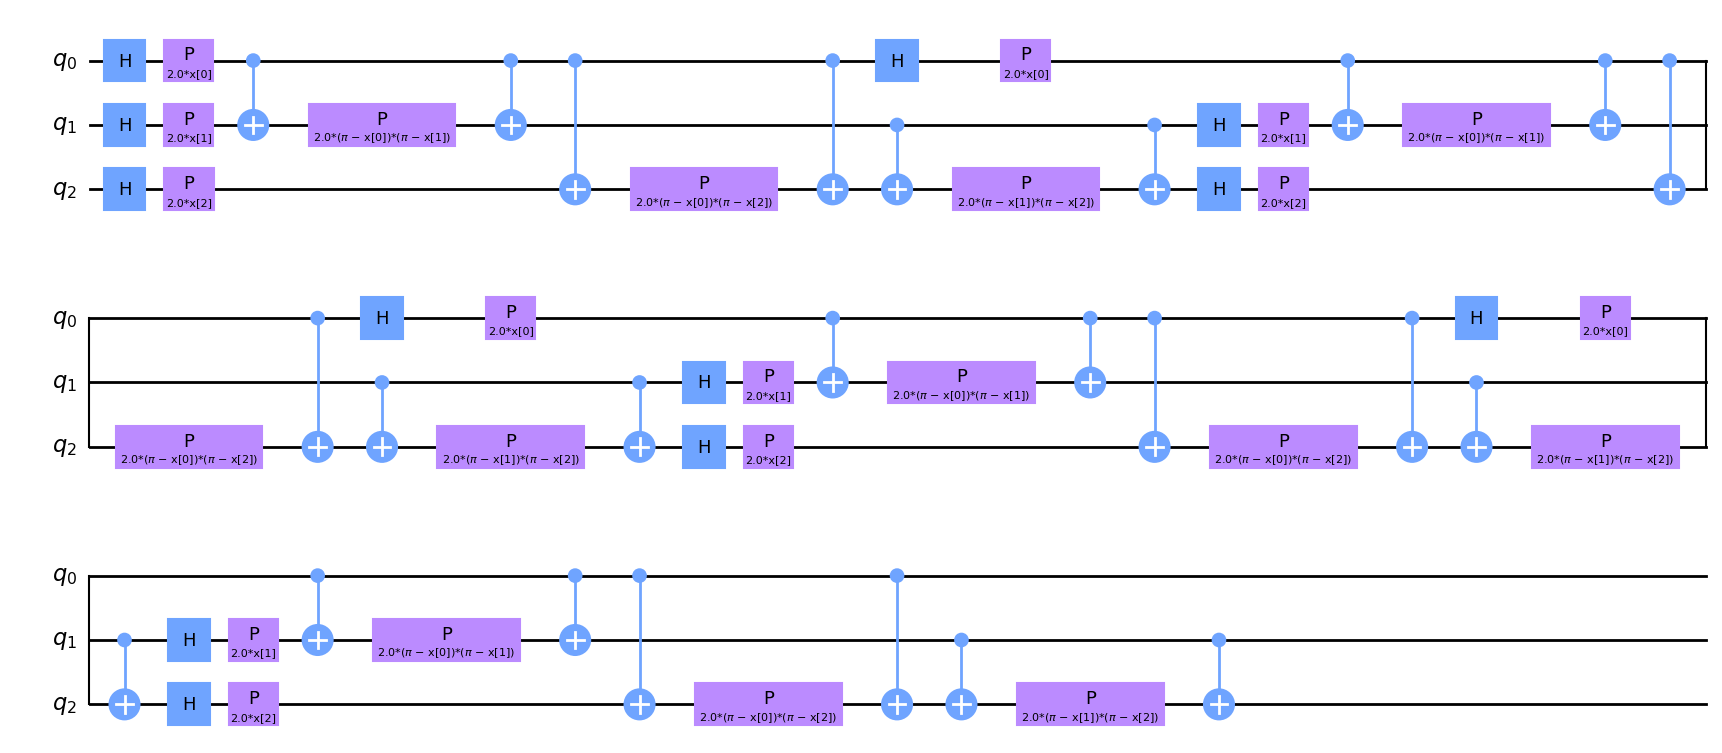

In [ ]:
# Initialize ZZFeatureMap with specified parameters
zz_feature_map = ZZFeatureMap(feature_dimension=3, reps=4)

# Decompose the circuit to see the underlying gates
decomposed_circuit = zz_feature_map.decompose()

# Now draw the decomposed circuit
decomposed_circuit.draw('mpl')

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(np.asmatrix(kernel_matrix), interpolation="nearest", origin="upper", cmap="Blues")
plt.title("Quantum clustering kernel matrix of synthetic dataset")
plt.show()

Plot the results

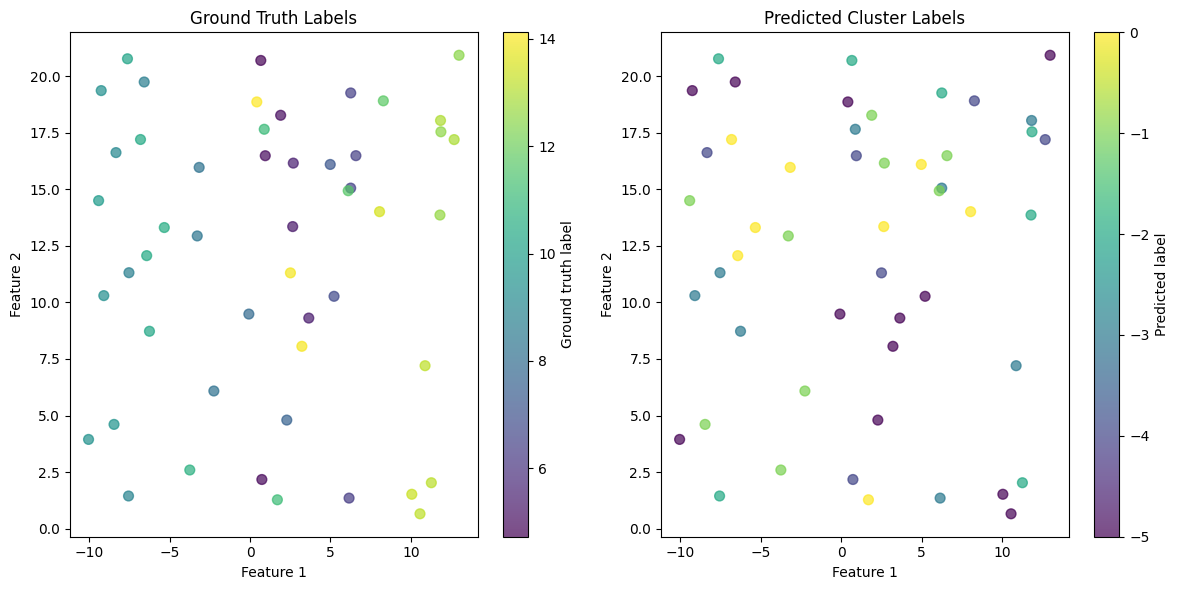

In [ ]:
# Plot the ground truth labels
plt.figure(figsize=(12, 6))

# Ground truth plot
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], c=color, cmap='viridis', s=50, alpha=0.7)
plt.title('Ground Truth Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Ground truth label')

# Predicted labels plot
plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], c=cluster_labels * -1, cmap='viridis', s=50, alpha=0.7)
plt.title('Predicted Cluster Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Predicted label')

plt.tight_layout()
plt.show()

### cancer breast dataset experiment

## Pauli Feature Map

We define a PauliFeatureMap with the following parameters:
- `feature_dimension`: The dimensionality of the feature space. This parameter is determined based on the dimensionality of the classical data.
- `reps`: The number of repetitions of the entangling layers in the quantum circuit.
- `paulis`: The Pauli operators to be used in the feature map. Here, we use 'X', 'Y', and 'ZZ' Pauli operators.

Then, we initialize a FidelityQuantumKernel with the PauliFeatureMap:
- `feature_map`: The PauliFeatureMap instance used for embedding.

Next, we compute the kernel matrix using the quantum kernel:
- `x_vec`: The classical data points to be embedded into the quantum space.

We initialize a SpectralClustering model with the following parameters:
- `n_clusters`: The number of clusters to identify. Here, we choose 2 clusters.
- `affinity`: The affinity matrix used to capture the relationship between data points. We use a precomputed affinity matrix obtained from the kernel matrix.

Then, we fit the SpectralClustering model to the precomputed affinity matrix and predict cluster labels for the data points.

Finally, we evaluate the clustering performance using the Normalized Mutual Information (NMI) score, which measures the agreement between the true labels and the predicted clusters. Higher NMI scores indicate better clustering performance.

### hyperparameter optimization

In [ ]:
def hyperparameter_optimization_paulifeaturemap(data, labels, feature_dimension, num_reps_range, n_clusters):
    best_score = 0
    best_params = None

    for num_reps in num_reps_range:
        # Initialize PauliFeatureMap with specified parameters
        pauli_feature_map = PauliFeatureMap(feature_dimension=feature_dimension, reps=num_reps, paulis=['X', 'Y', 'ZZ'])

        # Initialize FidelityQuantumKernel with PauliFeatureMap
        quantum_kernel = FidelityQuantumKernel(feature_map=pauli_feature_map)

        # Compute the kernel matrix using the quantum kernel
        kernel_matrix = quantum_kernel.evaluate(x_vec=data)

        # Initialize SpectralClustering model with specified number of clusters
        spectral_model = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')

        # Perform clustering on the precomputed affinity matrix
        cluster_labels = spectral_model.fit_predict(kernel_matrix)

        # Compute the Normalized Mutual Information (NMI) score for clustering evaluation
        cluster_score = normalized_mutual_info_score(cluster_labels, labels)

        # Check if the current score is better than the previous best score
        if cluster_score > best_score:
            best_score = cluster_score
            best_params = {'num_reps': num_reps, 'score': cluster_score}

    return best_params

### ad_hoc dataset experiment

In [ ]:
# Define the PauliFeatureMap
pauli_feature_map = PauliFeatureMap(feature_dimension=adhoc_dimension, reps=2, paulis=['X', 'Y', 'ZZ'])

# Initialize the FidelityQuantumKernel with the PauliFeatureMap
pauli_kernel = FidelityQuantumKernel(feature_map=pauli_feature_map)

# Compute the kernel matrix
pauli_kernel_matrix = pauli_kernel.evaluate(x_vec=train_features)

# Perform spectral clustering using the kernel matrix
pauli_spectral = SpectralClustering(n_clusters=2, affinity='precomputed')
pauli_cluster_labels = pauli_spectral.fit_predict(pauli_kernel_matrix)

# Evaluate the clustering performance
pauli_cluster_score = normalized_mutual_info_score(pauli_cluster_labels, train_labels)
print(f"Clustering score with PauliFeatureMap: {pauli_cluster_score}")

Clustering score with PauliFeatureMap: 0.18601418625157728


Plot the Quantum Circuit

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


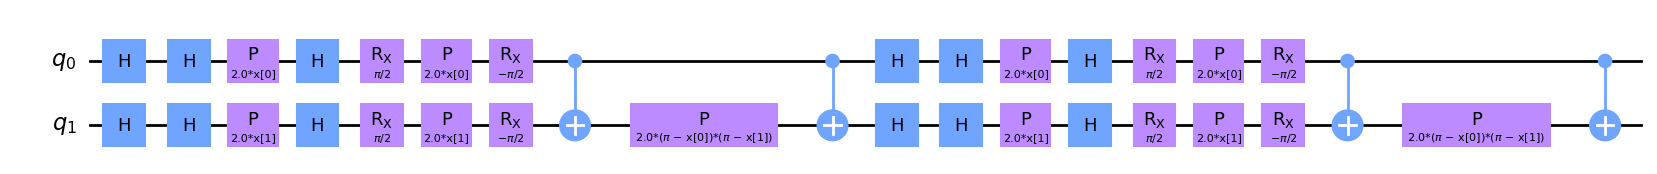

In [ ]:
# Initialize PauliFeatureMap with specified parameters
pauli_feature_map = PauliFeatureMap(feature_dimension=adhoc_dimension, reps=2, paulis=['X', 'Y', 'ZZ'])

# Decompose the circuit to see the underlying gates
decomposed_circuit = pauli_feature_map.decompose()

# Now draw the decomposed circuit
decomposed_circuit.draw('mpl')

### synthetic dataset experiment

In [ ]:
# Define the PauliFeatureMap
pauli_feature_map = PauliFeatureMap(feature_dimension=3, reps=4, paulis=['X', 'Y', 'ZZ'])

# Initialize the FidelityQuantumKernel with the PauliFeatureMap
pauli_kernel = FidelityQuantumKernel(feature_map=pauli_feature_map)

# Compute the kernel matrix
pauli_kernel_matrix = pauli_kernel.evaluate(x_vec=data)

# Perform spectral clustering using the kernel matrix
pauli_spectral = SpectralClustering(n_clusters=6, affinity='precomputed')
pauli_cluster_labels = pauli_spectral.fit_predict(pauli_kernel_matrix)

# Evaluate the clustering performance
pauli_cluster_score = normalized_mutual_info_score(pauli_cluster_labels, color)
print(f"Clustering score with PauliFeatureMap: {pauli_cluster_score}")

Clustering score with PauliFeatureMap: 0.5812621796747809


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Plot the Quantum Circuit

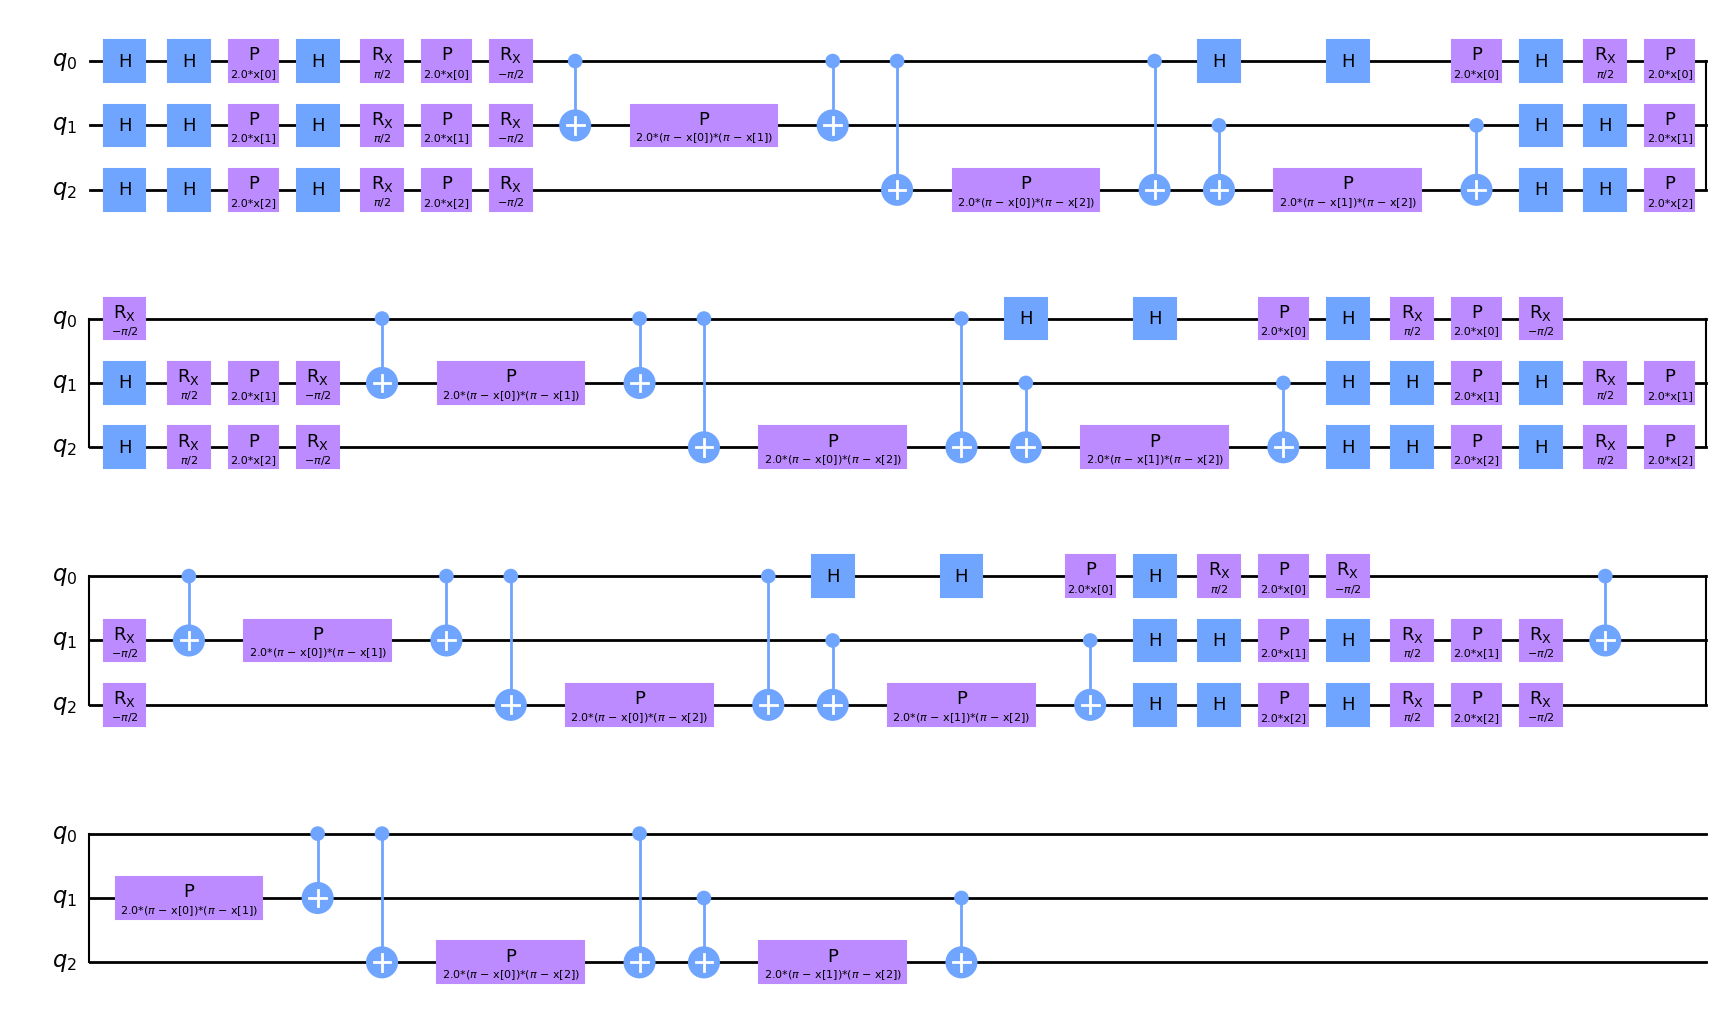

In [ ]:
# Initialize PauliFeatureMap with specified parameters
pauli_feature_map = PauliFeatureMap(feature_dimension=3, reps=4, paulis=['X', 'Y', 'ZZ'])

# Decompose the circuit to see the underlying gates
decomposed_circuit = pauli_feature_map.decompose()

# Now draw the decomposed circuit
decomposed_circuit.draw('mpl')

## Custom Feature Map

We define a custom quantum feature map using the following steps:

1. **Parameter Vector:** We create a parameter vector `x` of length `feature_dimension`, where `feature_dimension` is the dimensionality of the feature space.
2. **Quantum Circuit Initialization:** We initialize a QuantumCircuit with `feature_dimension` qubits.
3. **Parameterized Gates:** For each qubit in the circuit, we apply a Hadamard gate (`H`) followed by an RZ gate (`RZ`) parameterized by the corresponding parameter from the parameter vector.
4. **Entanglement Operations:** We add entangling operations, such as CNOT gates (`CX`), to create entanglement between qubits.

The custom feature map circuit thus created can capture intricate relationships between features in the dataset by adjusting the parameters of the gates.

We then initialize a FidelityQuantumKernel with the custom feature map and compute the kernel matrix using the quantum kernel. Next, we perform spectral clustering on the kernel matrix and evaluate the clustering performance using the Normalized Mutual Information (NMI) score.

This approach allows us to tailor the quantum feature map to the specific characteristics of our dataset, potentially leading to improved clustering results compared to predefined feature maps.

In [ ]:
def custom_feature_map(feature_dimension, reps=2):
    # Create a parameter vector for parameterized gates
    x = ParameterVector('x', length=feature_dimension)
    qc = QuantumCircuit(feature_dimension)

    for _ in range(reps):
        for i in range(feature_dimension):
            qc.h(i)  # Apply Hadamard gate
            qc.rz(x[i], i)  # Apply RZ gate parameterized by data
        for i in range(feature_dimension - 1):
            qc.cx(i, i + 1)  # Apply CNOT gate for entanglement
    return qc

### ad_hoc dataset experiment

In [ ]:
# Initialize the custom feature map
custom_map = custom_feature_map(feature_dimension=adhoc_dimension, reps=4)

# Initialize the FidelityQuantumKernel with the custom feature map
custom_kernel = FidelityQuantumKernel(feature_map=custom_map)

# Compute the kernel matrix
custom_kernel_matrix = custom_kernel.evaluate(x_vec=train_features)

# Perform spectral clustering using the kernel matrix
custom_spectral = SpectralClustering(n_clusters=2, affinity='precomputed')
custom_cluster_labels = custom_spectral.fit_predict(custom_kernel_matrix)

# Evaluate the clustering performance
custom_cluster_score = normalized_mutual_info_score(custom_cluster_labels, train_labels)
print(f"Clustering score with Custom Feature Map: {custom_cluster_score}")

Clustering score with Custom Feature Map: 0.059609011621941835


Plot the Quantum Circuit

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


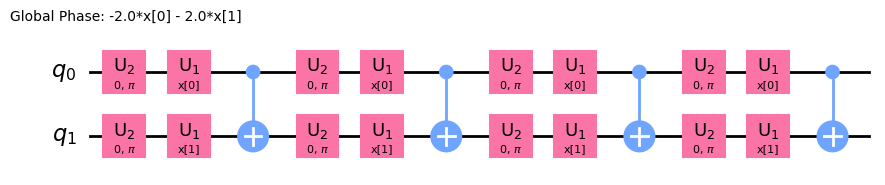

In [ ]:
# Initialize CustomFeatureMap with specified parameters
custom_map = custom_feature_map(feature_dimension=adhoc_dimension, reps=4)

# Decompose the circuit to see the underlying gates
decomposed_circuit = custom_map.decompose()

# Now draw the decomposed circuit
decomposed_circuit.draw('mpl')

### synthetic dataset experiment

In [ ]:
# Initialize the custom feature map
custom_map = custom_feature_map(feature_dimension=3, reps=4)

# Initialize the FidelityQuantumKernel with the custom feature map
custom_kernel = FidelityQuantumKernel(feature_map=custom_map)

# Compute the kernel matrix
custom_kernel_matrix = custom_kernel.evaluate(x_vec=data)

# Perform spectral clustering using the kernel matrix
custom_spectral = SpectralClustering(n_clusters=6, affinity='precomputed')
custom_cluster_labels = custom_spectral.fit_predict(custom_kernel_matrix)

# Evaluate the clustering performance
custom_cluster_score = normalized_mutual_info_score(custom_cluster_labels, color)
print(f"Clustering score with Custom Feature Map: {custom_cluster_score}")

Clustering score with Custom Feature Map: 0.62001894190303


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Plot the Quantum Circuit

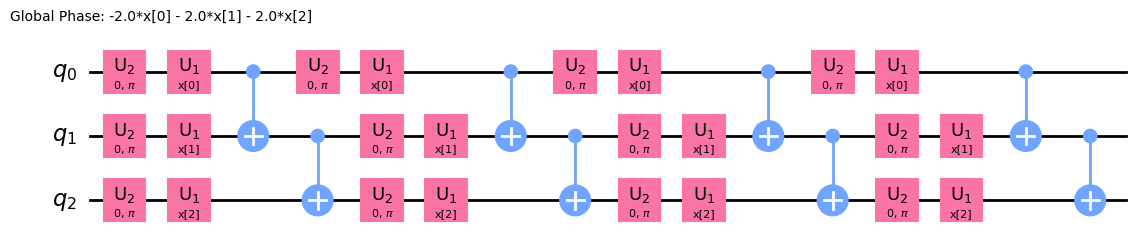

In [ ]:
# Initialize CustomFeatureMap with specified parameters
custom_map = custom_feature_map(feature_dimension=3, reps=4)

# Decompose the circuit to see the underlying gates
decomposed_circuit = custom_map.decompose()

# Now draw the decomposed circuit
decomposed_circuit.draw('mpl')

# Classic Spectral Clustering

We begin by defining a function `compute_affinity_matrix` to compute the affinity matrix, which captures the pairwise relationships between data points. This function computes the pairwise squared Euclidean distances between features and then uses a Gaussian kernel to transform these distances into similarities. The sigma parameter in the Gaussian kernel determines the width of the kernel, affecting the smoothness and connectivity of the affinity matrix.

We then perform hyperparameter optimization on the sigma value to identify the optimal scale for the Gaussian kernel. By varying the sigma parameter and evaluating the resulting clustering performance, we aim to find the sigma value that maximizes the agreement between the true labels and the predicted clusters.

The hyperparameter optimization process involves iterating over a range of sigma values, computing the affinity matrix for each sigma value, and evaluating the clustering performance using a clustering metric such as the Normalized Mutual Information (NMI) score.

## Hyperparameters optimization

In [ ]:
def optimize_sigma(train_features, train_labels, clusters=2):
    sigma_values = [0.1, 0.5, 1, 2, 3, 5]
    best_score = 0
    best_sigma = 0

    for sigma in sigma_values:
        affinity_matrix = compute_affinity_matrix(train_features, sigma)
        spectral_model = SpectralClustering(n_clusters=clusters, affinity='precomputed')
        cluster_labels = spectral_model.fit_predict(affinity_matrix)
        score = normalized_mutual_info_score(train_labels, cluster_labels)
        if score > best_score:
            best_score = score
            best_sigma = sigma

    print(f"Best Sigma: {best_sigma}, Best NMI Score: {best_score}")
    return best_sigma

## Vanilla Spectral Clustering

In [ ]:
def compute_affinity_matrix(features, sigma):
    # Compute pairwise squared Euclidean distances
    squared_distances = euclidean_distances(features, squared=True)
    # Compute the affinity matrix using the Gaussian kernel
    gamma = 1.0 / (2.0 * sigma ** 2)
    affinity_matrix = np.exp(-gamma * squared_distances)
    return affinity_matrix

### ad_hoc dataset experiment

In [ ]:
# Optimize sigma value for the Gaussian kernel
sigma = optimize_sigma(train_features, train_labels)

# Compute the affinity matrix using the optimized sigma
affinity_matrix = compute_affinity_matrix(train_features, sigma)

# Initialize SpectralClustering model with precomputed affinity matrix
spectral_model = SpectralClustering(n_clusters=2, affinity='precomputed')

# Perform spectral clustering on the affinity matrix
cluster_labels = spectral_model.fit_predict(affinity_matrix)

# Evaluate clustering performance using Normalized Mutual Information (NMI) score
cluster_score = normalized_mutual_info_score(cluster_labels, train_labels)

# Print the clustering score
print(f"Classic Spectral Clustering score with optimized sigma: {cluster_score}")

Best Sigma: 2, Best NMI Score: 0.04527634435678721
Classic Spectral Clustering score with optimized sigma: 0.04527634435678721


### synthetic dataset experiment

In [ ]:
# Preprocessing for continous values of the colors
num_classes = 6
color_labels = pd.cut(color, bins=num_classes, labels=range(num_classes))

# Ensure the labels are integers if they are not already
color_labels = color_labels.astype(int)

# Optimize sigma value for the Gaussian kernel
sigma = optimize_sigma(data, color_labels, clusters = 6)

# Compute the affinity matrix using the optimized sigma
affinity_matrix = compute_affinity_matrix(data, sigma)

# Initialize SpectralClustering model with precomputed affinity matrix
spectral_model = SpectralClustering(n_clusters=6, affinity='precomputed')

# Perform spectral clustering on the affinity matrix
cluster_labels = spectral_model.fit_predict(affinity_matrix)

# Evaluate clustering performance using Normalized Mutual Information (NMI) score
cluster_score = normalized_mutual_info_score(cluster_labels, color_labels)

# Print the clustering score
print(f"Classic Spectral Clustering score with optimized sigma: {cluster_score}")

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:420: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  est = KMeans(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited at iteration 223 with accuracies 
[4.72754180e-12 1.96690025e-08 5.48935002e-07 6.24643536e-07
 1.09372869e-06 5.96500005e-07 3.07481152e-07]
not reaching the requested tolerance 7.450580596923828e-07.
Use iteration 223 instead with accuracy 
4.558517310048552e-07.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[2.86757151e-13 1.96530197e-08 5.48943808e-07 6.24626800e-

Best Sigma: 2, Best NMI Score: 0.38993016502853944
Classic Spectral Clustering score with optimized sigma: 0.3899301650285395


plotting the results

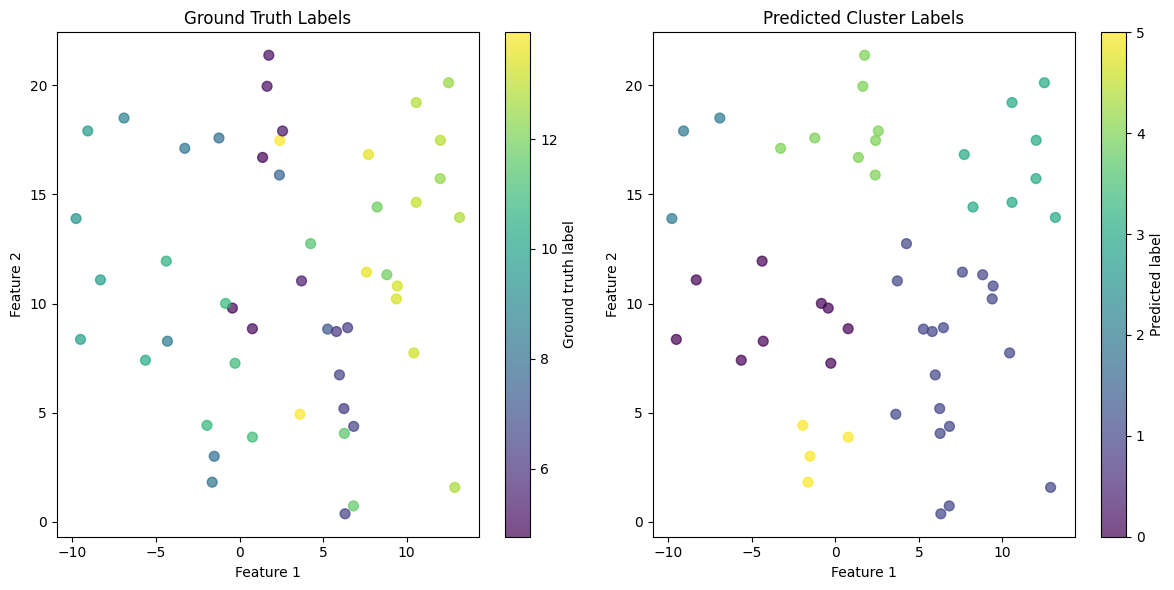

In [ ]:
# Plot the ground truth labels
plt.figure(figsize=(12, 6))

# Ground truth plot
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], c=color, cmap='viridis', s=50, alpha=0.7)
plt.title('Ground Truth Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Ground truth label')

# Predicted labels plot
plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.7)
plt.title('Predicted Cluster Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Predicted label')

plt.tight_layout()
plt.show()

## PCA Spectral Clustering

In [ ]:
def compute_affinity_matrix(features, sigma):
    # Compute pairwise squared Euclidean distances
    squared_distances = euclidean_distances(features, squared=True)
    # Compute the affinity matrix using the Gaussian kernel
    gamma = 1.0 / (2.0 * sigma ** 2)
    affinity_matrix = np.exp(-gamma * squared_distances)
    return affinity_matrix

### ad_hoc dataset experiment

In [ ]:
# Data preprocessing
scaler = StandardScaler()
features_scaled = scaler.fit_transform(train_features)

# Optionally, reduce dimensionality
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Use the optimized sigma for spectral clustering
sigma = optimize_sigma(features_pca, train_labels)
affinity_matrix = compute_affinity_matrix(features_pca, sigma)
spectral_model = SpectralClustering(n_clusters=2, affinity='precomputed')
cluster_labels = spectral_model.fit_predict(affinity_matrix)
cluster_score = normalized_mutual_info_score(cluster_labels, train_labels)
print(f"Classic Spectral Clustering score with optimized sigma: {cluster_score}")

Best Sigma: 0.1, Best NMI Score: 0.08068918390116712
Classic Spectral Clustering score with optimized sigma: 0.08068918390116712


plotting the results

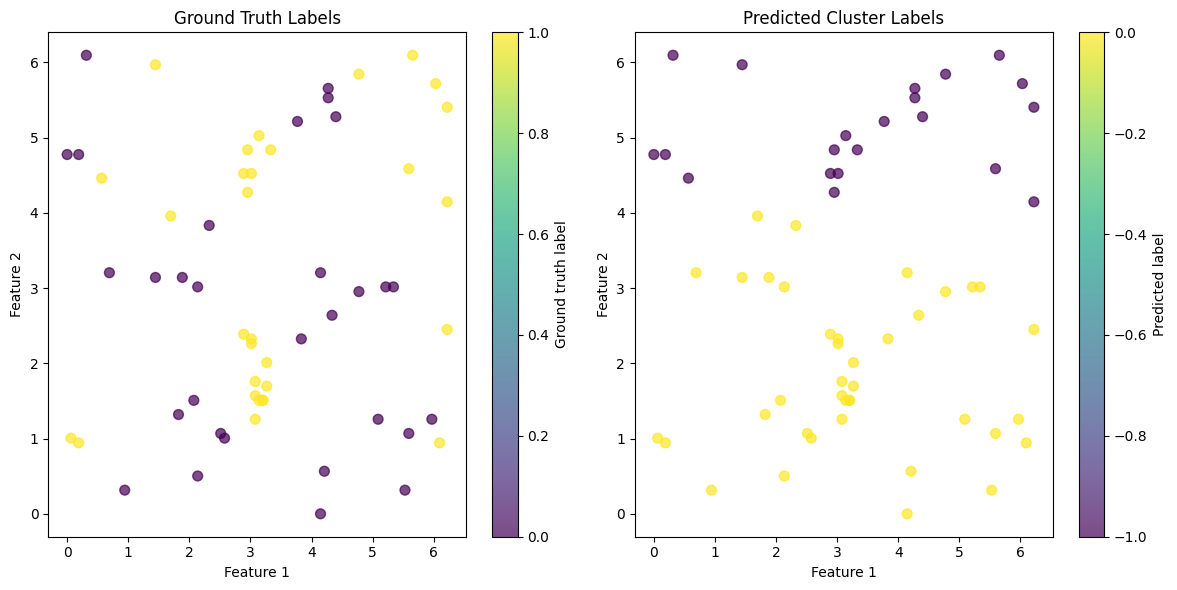

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'data' is your features (2D after PCA or t-SNE),
# 'color' is the ground truth labels, and 'cluster_labels' are the predicted labels

# Plot the ground truth labels
plt.figure(figsize=(12, 6))

# Ground truth plot
plt.subplot(1, 2, 1)
plt.scatter(train_features[:, 0], train_features[:, 1], c=train_labels, cmap='viridis', s=50, alpha=0.7)
plt.title('Ground Truth Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Ground truth label')

# Predicted labels plot
plt.subplot(1, 2, 2)
plt.scatter(train_features[:, 0], train_features[:, 1], c=cluster_labels * -1, cmap='viridis', s=50, alpha=0.7)
plt.title('Predicted Cluster Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Predicted label')

plt.tight_layout()
plt.show()

### synthetic dataset experiment

In [ ]:
# Data preprocessing
scaler = StandardScaler()
features_scaled = scaler.fit_transform(data)

# Optionally, reduce dimensionality
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Use the optimized sigma for spectral clustering
sigma = optimize_sigma(features_pca, color)
affinity_matrix = compute_affinity_matrix(features_pca, sigma)
spectral_model = SpectralClustering(n_clusters=6, affinity='precomputed')
cluster_labels = spectral_model.fit_predict(affinity_matrix)
cluster_score = normalized_mutual_info_score(cluster_labels, color)
#print(f"Classic Spectral Clustering score with optimized sigma: {cluster_score}")

# Multirun experiments

In this section we perform clustering experiments increasing the number of points of the dataset. The goal of this experiment is to understand how the accuracy of the cluster behave with the increasing number of points and measure the associated time complexity.

## Generate Dataset Function

**ad_hoc dataset**

In [ ]:
def generate_dataset(training_size, adhoc_dimension=2):
    """Generate the ad_hoc dataset with customizable training size."""
    train_features, train_labels, _, _, _ = ad_hoc_data(
        training_size=training_size,
        test_size=0,
        n=adhoc_dimension,
        gap=0.6,
        plot_data=False,
        one_hot=False,
        include_sample_total=True,
    )
    return train_features, train_labels

## Quantum Spectral Clustering Function

**ZZFeatureMap**

In [ ]:
def run_quantum_clustering(train_features, train_labels, n_clusters, reps=2):
    """Run quantum clustering on the provided dataset."""
    # Define the quantum kernel
    start_time = time.time()
    adhoc_feature_map = ZZFeatureMap(feature_dimension=train_features.shape[1], reps=reps, entanglement="linear")
    adhoc_kernel = FidelityQuantumKernel(feature_map=adhoc_feature_map)
    adhoc_matrix = adhoc_kernel.evaluate(x_vec=train_features)

    # Run quantum spectral clustering
    adhoc_spectral = SpectralClustering(2, affinity="precomputed")
    cluster_labels = adhoc_spectral.fit_predict(adhoc_matrix)
    end_time = time.time()

    # Compute clustering score
    clustering_score = normalized_mutual_info_score(cluster_labels, train_labels)

    # Compute execution time
    execution_time = end_time - start_time

    return clustering_score, execution_time

## Classic Spectral Clustering Function

**PCA spectral clustering**

In [ ]:
def run_pca_spectral_clustering(train_features, train_labels, n_clusters=2):
  "Run the PCA classic spectral clustering on the provided dataset"

  start_time = time.time()
  # Data preprocessing
  scaler = StandardScaler()
  features_scaled = scaler.fit_transform(train_features)

  # Optionally, reduce dimensionality
  pca = PCA(n_components=2)
  features_pca = pca.fit_transform(features_scaled)

  # Use the optimized sigma for spectral clustering
  sigma = optimize_sigma(features_pca, train_labels)
  affinity_matrix = compute_affinity_matrix(features_pca, sigma)
  spectral_model = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
  cluster_labels = spectral_model.fit_predict(affinity_matrix)

  end_time = time.time()

  cluster_score = normalized_mutual_info_score(cluster_labels, train_labels)
  execution_time = end_time - start_time

  return cluster_score, execution_time

**vanilla spectral clustering**

In [ ]:
def run_spectral_clustering(train_features, train_labels, n_clusters):
    "Run the vanilla spectral clustering on the provided dataset"
    start_time = time.time()

    sigma = optimize_sigma(train_features, train_labels)
    affinity_matrix = compute_affinity_matrix(train_features, sigma)

    # Spectral Clustering
    n_clusters = n_clusters  # Or the desired number of clusters
    spectral_model = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
    cluster_labels = spectral_model.fit_predict(affinity_matrix)
    end_time = time.time()

    # Evaluation
    cluster_score = normalized_mutual_info_score(cluster_labels, train_labels)

    # Execution time
    execution_time = end_time - start_time

    return cluster_score, execution_time

## Run Experiments

In [ ]:
def custom_progression(start, end, length):
    ratio = (end / start) ** (1 / (length - 1))
    return [int(start * (ratio ** i)) for i in range(length)]

In [ ]:
# Define parameters
num_experiments = 3
n_clusters = 2
#training_sizes = np.logspace(1, 3, num=num_experiments, dtype=int)
training_sizes = custom_progression(start=10, end=200, length=num_experiments)

# Collect results
scores_quantum = []
times_quantum = []

#scores_vanilla = []
#times_vanilla = []

scores_pca = []
times_pca = []

In [ ]:
print(training_sizes)

[10, 44, 200]


**PCA classic vs ZZFeatureMap quantum**

In [ ]:
# Initialize tqdm with the total number of iterations
for training_size in tqdm(training_sizes, desc='Running experiments', unit='experiment'):
    # Define dataset
    train_features, train_labels = generate_dataset(training_size)

    # Run the algorithms
    score_quantum, execution_time_quantum = run_quantum_clustering(train_features, train_labels, n_clusters)
    score_pca, execution_time_pca = run_pca_spectral_clustering(train_features, train_labels, n_clusters)

    # Store the results
    scores_quantum.append(score_quantum)
    times_quantum.append(execution_time_quantum)

    scores_pca.append(score_pca)
    times_pca.append(execution_time_pca)
    print(f"Training size: {training_size}, Quantum Score: {score_quantum} vs Vanilla Score: {score_pca}, Quantum Time: {execution_time_quantum:.4f} s vs Vanilla Time: {execution_time_pca:.4f} s")


Running experiments:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/experiment]

Best Sigma: 2, Best NMI Score: 0.00732562257195427
Training size: 10, Quantum Score: 0.7610260716417302 vs Vanilla Score: 0.00732562257195427, Quantum Time: 0.8656 s vs Vanilla Time: 0.0931 s


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited at iteration 2000 with accuracies 
[4.84506379e-15 1.02261520e-06 7.17522861e-06]
not reaching the requested tolerance 1.3113021850585938e-06.
Use iteration 1934 instead with accuracy 
1.711383696002443e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[2.90408728e-15 1.69492461e-06 3.43834616e-06]
not reaching the requested tolerance 1.3113021850585938e-06.
  _, diffusion_map = lobpcg(


Best Sigma: 0.1, Best NMI Score: 0.06512688848442015


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited at iteration 2000 with accuracies 
[4.85944529e-15 1.34060025e-06 7.10985007e-06]
not reaching the requested tolerance 1.3113021850585938e-06.
Use iteration 1500 instead with accuracy 
1.0719306482728404e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[2.65744367e-15 6.32179080e-07 2.58378064e-06]
not reaching the requested tolerance 1.3113021850585938e-06.
  _, diffusion_map = lobpcg(
Running experiments:  67%|██████▋   | 2/3 [00:19<00:11, 11.09s/experiment]

Training size: 44, Quantum Score: 1.0 vs Vanilla Score: 0.039963247007077624, Quantum Time: 12.8306 s vs Vanilla Time: 4.4915 s


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited at iteration 2000 with accuracies 
[6.56779801e-15 1.35734863e-06 1.72079121e-05]
not reaching the requested tolerance 5.9604644775390625e-06.
Use iteration 1751 instead with accuracy 
4.55073392438036e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[6.55602869e-15 1.48119688e-06 1.21711011e-05]
not reaching the requested tolerance 5.9604644775390625e-06.
  _, diffusion_map = lobpcg(


Best Sigma: 2, Best NMI Score: 0.0026694535914456633


Running experiments: 100%|██████████| 3/3 [05:09<00:00, 103.27s/experiment]

Training size: 200, Quantum Score: 1.0 vs Vanilla Score: 0.0026694535914456633, Quantum Time: 278.4636 s vs Vanilla Time: 11.0491 s


## Plot Results

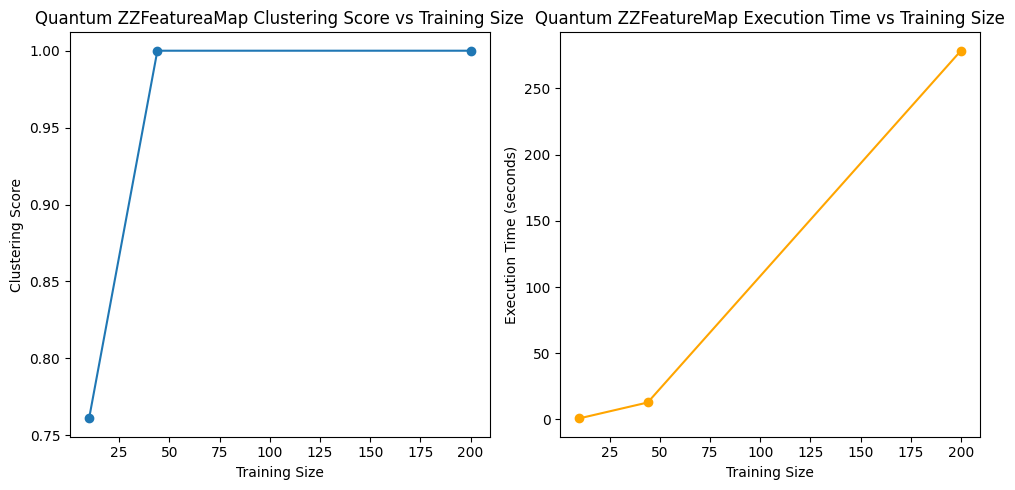

In [ ]:
# Plot results Quantum
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_sizes, scores_quantum[1:], marker='o')
plt.title('Quantum ZZFeatureaMap Clustering Score vs Training Size')
plt.xlabel('Training Size')
plt.ylabel('Clustering Score')

plt.subplot(1, 2, 2)
plt.plot(training_sizes, times_quantum[1:], marker='o', color='orange')
plt.title('Quantum ZZFeatureMap Execution Time vs Training Size')
plt.xlabel('Training Size')
plt.ylabel('Execution Time (seconds)')

plt.tight_layout()
plt.show()

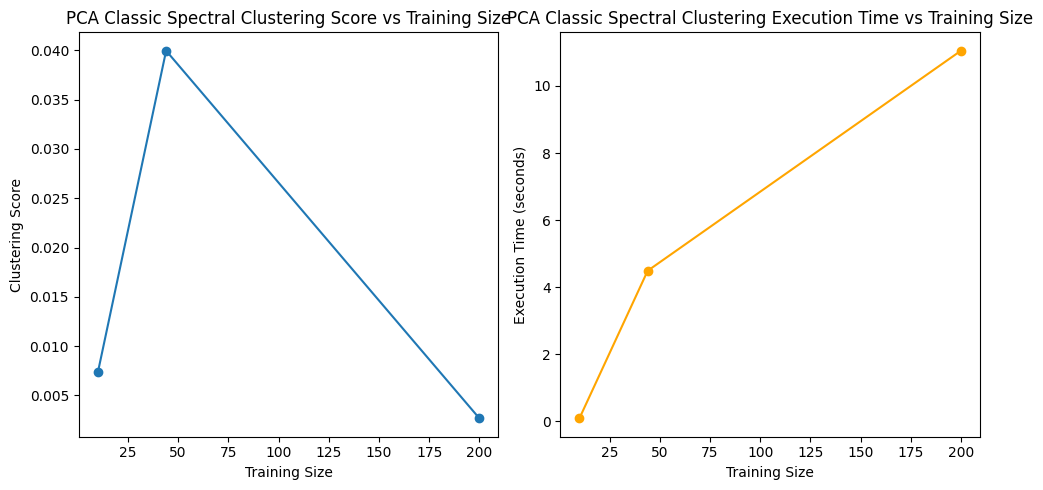

In [ ]:
# Plot results Vanilla
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_sizes, scores_pca, marker='o')
plt.title('PCA Classic Spectral Clustering Score vs Training Size')
plt.xlabel('Training Size')
plt.ylabel('Clustering Score')

plt.subplot(1, 2, 2)
plt.plot(training_sizes, times_pca, marker='o', color='orange')
plt.title('PCA Classic Spectral Clustering Execution Time vs Training Size')
plt.xlabel('Training Size')
plt.ylabel('Execution Time (seconds)')

plt.tight_layout()
plt.show()

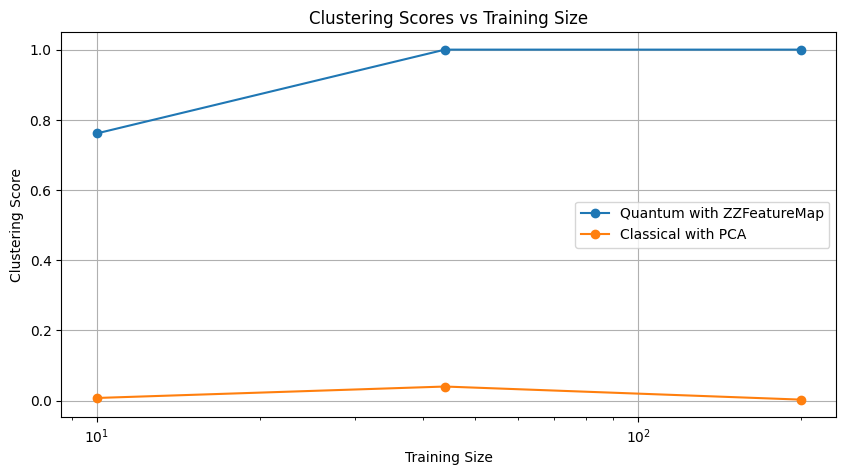

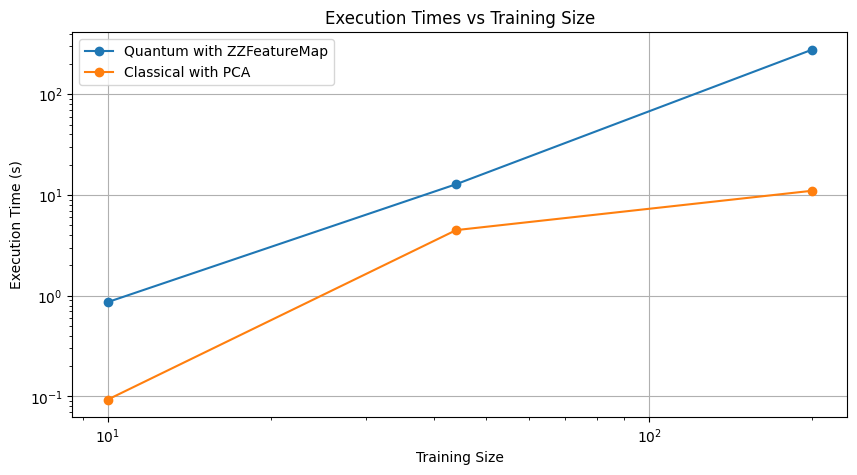

In [ ]:
# Plot scores Quantum vs Vanilla
plt.figure(figsize=(10, 5))
plt.plot(training_sizes, scores_quantum[1:], marker='o', label='Quantum with ZZFeatureMap')
plt.plot(training_sizes, scores_pca, marker='o', label='Classical with PCA')
plt.title('Clustering Scores vs Training Size')
plt.xlabel('Training Size')
plt.ylabel('Clustering Score')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Plot execution times
plt.figure(figsize=(10, 5))
plt.plot(training_sizes, times_quantum[1:], marker='o', label='Quantum with ZZFeatureMap')
plt.plot(training_sizes, times_pca, marker='o', label='Classical with PCA')
plt.title('Execution Times vs Training Size')
plt.xlabel('Training Size')
plt.ylabel('Execution Time (s)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()